In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler


import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

In [2]:
torch.manual_seed(42)
np.random.seed(42)

os.environ["OMP_NUM_THREADS"] = "1"

step = 0.003               # Learning rate

batch_size = 32              # Number of samples for each training step
num_epochs = 50              # Number of training epochs

gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
start_time = time.time()    # Start of the computation timer

train_all_loss=[]
train_all_acc=[]
val_all_loss=[]
val_all_acc=[]
best_accuracy=0

device = torch.device("cpu")

In [3]:
train_f=[[326, 1797, 1868, 2352, 2897, 2919, 3213, 3247, 3259, 3328, 3610, 5342, 5498, 5505, 6008, 6648, 6935, 7127, 7585, 7589, 7846, 7882, 8894, 8961, 9005, 9310, 9806, 9922, 9985, 10254, 10259, 10938, 12020, 12168, 12184, 12313, 12665, 13164, 13206, 13497, 13989, 14097, 14511, 15454, 15582, 16888, 16941, 17452, 17458, 19009, 19216, 19325, 19689, 19899, 19902, 20388, 21560, 21612, 21932, 22152, 22589, 22832, 22877, 23250, 23277, 23613, 23821, 25497, 25814, 26139, 26262, 27283, 27326, 28102, 28427, 29230, 29848, 30678, 31466, 31808, 32746, 33492, 33732, 33776, 33831, 34302, 34555, 35408, 35432, 36031, 36090, 36797, 36894, 37678, 38099, 38355, 38802, 38993, 39220, 39581, 39631, 40544, 41069, 41137, 41627, 41643, 42358, 42634, 42867, 43129, 44730, 46144, 46227, 46398, 46560, 46917, 47241, 47482, 47690, 47756, 47835, 48026, 48267, 48815, 49304, 49322, 49354, 49621, 50385, 50463, 51041, 51052, 51308, 52028, 52429, 52438, 53354, 53429, 54351, 54783, 54980, 55275, 57525, 58362, 58864, 59267, 59288, 59615, 59840, 59901], [124, 470, 533, 1277, 1458, 3723, 4813, 5012, 5107, 5429, 5494, 5903, 5930, 6226, 6511, 6537, 6880, 7404, 7440, 8194, 8423, 8430, 8471, 8575, 8615, 9399, 9622, 9842, 10985, 11395, 11432, 11607, 12106, 12909, 12987, 14221, 14701, 14812, 16203, 16259, 16735, 17130, 17639, 17695, 17888, 18647, 19441, 19486, 20146, 20654, 21143, 21200, 21535, 21771, 22533, 22705, 23254, 23291, 23417, 23931, 24247, 24580, 24688, 25785, 26812, 27454, 28056, 28069, 28292, 28815, 29227, 29407, 30073, 30869, 30901, 31122, 31447, 31963, 32070, 32231, 32482, 32486, 32705, 33667, 35865, 36380, 36532, 37045, 37182, 37725, 37741, 38095, 38384, 38595, 38707, 38845, 38928, 39652, 39757, 40909, 41011, 41055, 41076, 41103, 41474, 41554, 41723, 41839, 42093, 43872, 44431, 44493, 44677, 45541, 45556, 45641, 46196, 47004, 47310, 47697, 48236, 48411, 49167, 49855, 50225, 51112, 51206, 51468, 51847, 52119, 52381, 52868, 53206, 53273, 54123, 54614, 54651, 54876, 55596, 56605, 56870, 56965, 57169, 57684, 58557, 58810, 59153, 59247, 59750, 59902], [262, 444, 1374, 1874, 2270, 2517, 3329, 3836, 3934, 4322, 4341, 4846, 5659, 5715, 6144, 6628, 6637, 6764, 7265, 8211, 8226, 8413, 8617, 8939, 9600, 9668, 9964, 11033, 11110, 12053, 12424, 12621, 13535, 14244, 15185, 15223, 15688, 16089, 16289, 17315, 18499, 18930, 19415, 19519, 19919, 20424, 20442, 21597, 21802, 22021, 22112, 22341, 22369, 22486, 22922, 23460, 24238, 24649, 24786, 24841, 25138, 25994, 26595, 27093, 27571, 27761, 28074, 28212, 28537, 28795, 28844, 28950, 29413, 29612, 29619, 29784, 31617, 31662, 31874, 32438, 32510, 32650, 32825, 33007, 33438, 33489, 33540, 33680, 34405, 34789, 36016, 36396, 36423, 36505, 37484, 37486, 37660, 38078, 38124, 38171, 39153, 39256, 39282, 39840, 40212, 40569, 40899, 41197, 41438, 41794, 42142, 42842, 42861, 43079, 43176, 43842, 43885, 44541, 44657, 45085, 45206, 46239, 46317, 46586, 47780, 48147, 48476, 48748, 50454, 50576, 50640, 52099, 52841, 53013, 54541, 54573, 55692, 55808, 56394, 56513, 56752, 57624, 57654, 57831, 58068, 58254, 58502, 59177, 59476, 59819], [341, 356, 479, 752, 1436, 1677, 1994, 2029, 3013, 3233, 3424, 3844, 4191, 4359, 5067, 5148, 5328, 5974, 6148, 6216, 6450, 7625, 7881, 8254, 8605, 9355, 9363, 9491, 9623, 9851, 9915, 10052, 11259, 12307, 12826, 13383, 13670, 13980, 14028, 14177, 14736, 14935, 15045, 15372, 15486, 15937, 17026, 17155, 17242, 17274, 17632, 17673, 18007, 18375, 18503, 18549, 18939, 20329, 20377, 20437, 21468, 21515, 22460, 22488, 22567, 23649, 24017, 24132, 24369, 24575, 25331, 26156, 26378, 26419, 26448, 26678, 29610, 29816, 29894, 30540, 30774, 30974, 31032, 31667, 31759, 31962, 32663, 33000, 34105, 34183, 34364, 34736, 35208, 35744, 36103, 36216, 36449, 37244, 37703, 37903, 38772, 38982, 39675, 39678, 40121, 40490, 40639, 42041, 42419, 42677, 44020, 44188, 44510, 45008, 45687, 46062, 46208, 46702, 47441, 47469, 47669, 47689, 47834, 47979, 48163, 48193, 48798, 49589, 50253, 50950, 51116, 53158, 53365, 53903, 54535, 54707, 55488, 56474, 56492, 56817, 57172, 57341, 57568, 57864, 58410, 58642, 58729, 58758, 59062, 59137], [164, 354, 661, 877, 991, 1079, 1280, 1448, 2390, 2689, 3388, 4346, 4436, 5002, 5581, 5807, 6596, 6672, 6674, 7166, 7734, 7974, 8086, 8344, 8508, 8567, 8869, 9149, 9385, 10252, 10433, 11227, 11913, 12873, 12955, 13541, 13841, 13908, 14411, 14602, 15059, 15207, 17268, 18000, 18190, 18905, 19299, 19404, 19795, 20907, 21140, 21461, 21627, 21916, 22064, 22071, 22355, 23274, 23999, 24161, 24296, 24340, 24869, 24929, 25353, 25396, 26367, 26879, 26890, 26897, 27141, 27552, 27584, 28036, 28706, 28767, 29206, 29358, 29638, 29992, 30151, 30276, 30702, 31126, 31580, 31668, 31717, 31793, 32328, 32524, 32628, 32769, 33552, 33747, 34349, 35402, 35493, 36296, 36923, 37076, 37128, 37294, 37899, 38131, 39607, 41930, 42411, 42711, 43073, 43395, 43571, 43600, 44301, 44593, 45017, 46691, 46922, 47086, 47674, 48068, 48535, 48953, 48961, 49015, 50005, 50216, 51264, 51270, 51678, 52103, 52274, 52642, 52852, 52996, 53384, 54017, 54778, 55005, 56072, 56244, 56763, 57704, 58184, 58225, 58433, 58514, 59335, 59657, 59743, 59943], [407, 437, 899, 970, 1961, 2281, 2328, 3118, 3634, 4558, 5456, 6018, 6274, 6680, 6988, 7091, 7172, 7833, 7917, 7967, 9159, 9228, 9859, 10961, 12269, 13784, 13863, 14714, 14799, 15070, 15462, 15571, 15655, 15804, 16092, 17572, 18340, 18508, 19318, 19717, 20101, 20342, 20804, 20837, 21227, 21365, 21588, 22935, 22951, 23434, 23668, 24332, 24630, 25659, 25726, 25793, 25997, 26020, 26370, 26460, 26891, 27400, 27593, 27745, 28952, 29008, 29616, 30285, 30405, 31010, 31078, 31819, 31946, 32724, 32755, 32758, 32870, 33081, 33562, 33972, 34148, 34400, 34438, 34448, 34692, 34858, 35041, 35310, 35495, 36111, 36256, 36361, 36804, 37086, 37592, 38234, 38254, 38459, 39311, 40518, 40704, 40711, 40868, 41023, 42436, 42756, 42760, 43021, 43159, 43574, 43587, 43641, 43803, 44235, 45003, 45292, 45334, 45607, 45870, 46307, 46448, 46924, 47146, 48046, 48113, 48814, 49132, 49427, 49611, 49992, 50187, 50399, 51072, 51562, 51950, 52527, 53443, 53675, 54159, 54189, 54598, 54868, 55212, 55388, 55685, 56262, 57251, 57497, 57814, 59291], [401, 597, 658, 1117, 1184, 1424, 1456, 1731, 2324, 2607, 2756, 2836, 2898, 3127, 3654, 3671, 4087, 4683, 4882, 5018, 5231, 5329, 5671, 6265, 6482, 6574, 7064, 7104, 7577, 7598, 8009, 8149, 8733, 9460, 9813, 11289, 11635, 11759, 12523, 13101, 14072, 14155, 14377, 14989, 15708, 16255, 17011, 17287, 17616, 18199, 18262, 18303, 19062, 19331, 19712, 20113, 20136, 20891, 21290, 22075, 22145, 22709, 23075, 24023, 24037, 24224, 24458, 25047, 26039, 26168, 26393, 26563, 28382, 28425, 29035, 29272, 29838, 30232, 30648, 30727, 31368, 31557, 31998, 33549, 33601, 33751, 34046, 34456, 34543, 35140, 35322, 35377, 35616, 35768, 35917, 36129, 36527, 36581, 36601, 36637, 36905, 37037, 37217, 37235, 38192, 38258, 38334, 38659, 40244, 40475, 41273, 41790, 41975, 41988, 42541, 42611, 44168, 45157, 46323, 46646, 47524, 47611, 47687, 48328, 48491, 49022, 49659, 49765, 50865, 51069, 51619, 52380, 53111, 53175, 53828, 54288, 54409, 54771, 54841, 55012, 55387, 55942, 57012, 57413, 57557, 57742, 58016, 58304, 58807, 59431], [141, 243, 377, 436, 654, 1619, 1656, 2054, 2229, 2431, 3010, 3448, 3507, 3617, 4211, 4519, 5975, 6053, 7001, 7509, 8217, 8436, 8576, 8717, 9343, 9356, 10077, 11085, 12296, 12464, 12492, 13056, 13136, 13329, 13744, 13755, 13756, 13867, 13933, 14586, 14601, 14750, 14891, 15037, 15209, 15518, 15690, 15932, 16186, 16505, 16700, 17114, 17343, 17481, 17798, 18204, 18793, 19023, 19086, 19509, 19511, 19663, 20295, 20403, 20707, 21050, 21761, 21834, 22497, 22826, 23603, 23782, 24382, 24565, 24723, 26056, 26489, 26568, 26600, 27103, 27554, 27574, 28529, 28775, 29212, 29443, 29694, 29730, 30339, 30462, 31073, 31187, 31967, 32649, 32835, 33134, 34298, 34951, 35199, 35594, 35648, 36760, 38017, 39026, 39371, 39813, 41151, 41224, 41300, 42134, 42292, 42592, 43143, 43627, 43722, 43796, 44175, 44178, 44971, 45329, 45457, 46615, 46641, 47049, 47417, 47677, 48080, 48519, 48832, 48944, 49933, 50255, 51300, 51958, 52861, 52911, 53171, 53635, 54558, 54734, 55422, 55544, 55700, 56132, 56462, 57866, 58143, 58282, 58890, 59124], [225, 485, 499, 885, 1439, 1542, 2384, 3040, 3254, 3497, 3688, 3845, 3958, 3968, 4803, 5078, 5853, 7121, 7307, 7575, 8181, 9234, 9537, 9762, 9847, 10837, 11239, 11858, 12513, 12904, 13559, 13917, 13920, 14170, 14831, 15321, 15623, 15782, 16637, 17768, 17999, 18369, 18711, 20352, 20648, 20712, 21282, 22261, 22469, 23071, 23215, 23650, 24007, 24534, 24558, 25400, 25415, 25418, 25657, 25763, 25819, 25984, 26474, 26491, 26496, 27616, 28241, 29531, 30111, 30162, 30407, 30478, 30732, 30743, 31800, 32596, 33181, 33289, 33387, 33997, 34563, 34804, 35577, 35967, 35997, 36224, 36751, 36776, 37178, 37342, 37813, 37885, 37956, 38069, 38146, 38587, 38805, 38971, 40814, 41017, 41064, 41578, 42987, 43335, 44616, 45050, 45223, 45463, 45772, 46034, 46776, 46942, 47144, 47387, 47484, 48092, 48115, 49279, 49400, 49999, 50001, 50106, 50410, 50442, 50715, 52280, 52485, 52890, 53079, 53115, 53281, 53440, 53653, 54136, 54612, 55081, 55674, 55853, 56255, 56872, 56894, 57210, 57484, 57561, 57901, 58305, 58424, 59086, 59837, 59967], [525, 1684, 1740, 1811, 2267, 3998, 5522, 5746, 6174, 6272, 6382, 6383, 6518, 6934, 7627, 8035, 8066, 8141, 8308, 9838, 10070, 11485, 11515, 11853, 12607, 13032, 13672, 13695, 13893, 14247, 14324, 14915, 15131, 15413, 15414, 15832, 16152, 16635, 16702, 16775, 16854, 16934, 18138, 18561, 18694, 19185, 19255, 19417, 19558, 19938, 21645, 22283, 22319, 22406, 24243, 24270, 24454, 24694, 24701, 25624, 26513, 27107, 27766, 27884, 27949, 29113, 29332, 30205, 30208, 30551, 30633, 30701, 30942, 31337, 31565, 31621, 31923, 32777, 32904, 33130, 33422, 33783, 33862, 34306, 34668, 37162, 37306, 37424, 37457, 37781, 38005, 38899, 39753, 39869, 40177, 40250, 40325, 41270, 41905, 41983, 42924, 43086, 43325, 44402, 44884, 44982, 45074, 45232, 45440, 45917, 46023, 46064, 46193, 47126, 48297, 49213, 49462, 50490, 50544, 50851, 51156, 51770, 51985, 52123, 52653, 52843, 53397, 53845, 53976, 54144, 54467, 54578, 55711, 55783, 55856, 56323, 56577, 56599, 57421, 57545, 57638, 57657, 58366, 58742, 58838, 58854, 58898, 59564, 59748, 59917]]
valid_f=[[1078, 1775, 2736, 3734, 4008, 6292, 6394, 6461, 7378, 9506, 10384, 10530, 11403, 13314, 14419, 15288, 15567, 21533, 21898, 23131, 24320, 25167, 26184, 26323, 27628, 27633, 29520, 30080, 30828, 30923, 34057, 34345, 35739, 37506, 40240, 41038, 42871, 43631, 46905, 48218, 48554, 48729, 49996, 50328, 51314, 53117, 55290, 55830, 55907, 57887], [648, 835, 1472, 5552, 8053, 9085, 11249, 13630, 15865, 17964, 18035, 22735, 23390, 23795, 23886, 26144, 27345, 27572, 28411, 28834, 30512, 31038, 32974, 34922, 35436, 36037, 38526, 39843, 40052, 40779, 40971, 42899, 42974, 43246, 43972, 44046, 44988, 47272, 47985, 49205, 50577, 51252, 51936, 53930, 54576, 55142, 55386, 57948, 58689, 59519], [688, 714, 1447, 4293, 4986, 5306, 7344, 7879, 8977, 9715, 10100, 10567, 14694, 15123, 15263, 16925, 17269, 17489, 20655, 21425, 22407, 23058, 25732, 27189, 27232, 28156, 29019, 29408, 30881, 31146, 31905, 33691, 33698, 34657, 38563, 38862, 43191, 44049, 45041, 46092, 46408, 46543, 47819, 52152, 55782, 56312, 56569, 57439, 57475, 58297], [1737, 4262, 4808, 5186, 5497, 5753, 7162, 8865, 10779, 12901, 13965, 14619, 16296, 17352, 18343, 20868, 22293, 23047, 23879, 26033, 26824, 27287, 28359, 29246, 29459, 30754, 30824, 31155, 35805, 36057, 37789, 38116, 40401, 42178, 42255, 43672, 43967, 45655, 46354, 46692, 47803, 49318, 50378, 53412, 53586, 53740, 54746, 55341, 57804, 59151], [342, 363, 413, 3652, 10114, 10558, 10912, 11113, 12285, 12915, 14047, 14528, 15840, 16293, 16314, 17498, 17576, 18420, 18487, 19076, 21664, 23664, 24745, 26763, 28518, 28615, 29256, 32787, 33070, 33626, 33702, 34683, 35229, 35852, 35946, 37530, 38072, 38175, 39584, 40062, 40970, 41163, 42816, 43010, 44894, 48195, 50149, 53768, 56316, 57459], [35, 173, 273, 2131, 2690, 2968, 3467, 4113, 4752, 6180, 7159, 10598, 11739, 12110, 12996, 13368, 15855, 17436, 17461, 18929, 19207, 21034, 21360, 21397, 23226, 24202, 25084, 26572, 27422, 27526, 27764, 28116, 28315, 31944, 35350, 35858, 36739, 41945, 41970, 43648, 45919, 47081, 48058, 52065, 55572, 56229, 56852, 58381, 58456, 58663], [221, 536, 739, 1889, 2954, 4090, 4546, 8074, 8500, 8940, 9967, 10540, 11803, 12170, 14248, 14328, 16452, 16507, 16695, 16821, 17034, 17221, 20744, 21762, 22425, 22615, 23922, 25684, 27523, 27653, 27757, 28170, 28966, 30045, 31670, 34963, 35219, 36285, 37542, 39121, 39353, 39406, 40560, 41695, 42729, 45395, 50402, 51310, 57353, 58043], [258, 1673, 2673, 3692, 4273, 8499, 9395, 11488, 11660, 11907, 12000, 13905, 15199, 15577, 17776, 18951, 19312, 20310, 20582, 21662, 25121, 25469, 26303, 27823, 28880, 29727, 31542, 31550, 32645, 34047, 34459, 34914, 36563, 38598, 42363, 44194, 46717, 48050, 48562, 48610, 49372, 49719, 51000, 51294, 52568, 56266, 57215, 57479, 58272, 58681], [3499, 7871, 9369, 9952, 9970, 10862, 11555, 13083, 13476, 14923, 15033, 17170, 17672, 19103, 20785, 21708, 22060, 22604, 22760, 22965, 25276, 26373, 26661, 28432, 29627, 32907, 35713, 37527, 37909, 38596, 38863, 39499, 40146, 41621, 42060, 42832, 43986, 44615, 46428, 47008, 48110, 49323, 52033, 52573, 54006, 54550, 55880, 57870, 59129, 59946], [1291, 1912, 2351, 2521, 2793, 3382, 4315, 4690, 5137, 5390, 6067, 6821, 7198, 7241, 12342, 12846, 14459, 15858, 17666, 18241, 19913, 20641, 21981, 26440, 27581, 27774, 27863, 29419, 29846, 29878, 31057, 31184, 35694, 37233, 37318, 42090, 44384, 44592, 46828, 47103, 49272, 49313, 50304, 52718, 54251, 54571, 56580, 57175, 58470, 58968]]
test_f=[[13, 327, 644, 704, 1121, 1220, 1650, 1712, 2485, 3178, 3179, 3413, 3989, 4392, 4672, 4880, 5006, 5243, 5452, 5695, 5838, 6082, 6133, 6293, 6424, 6470, 6546, 6580, 6795, 7133, 7139, 7168, 7337, 7354, 7410, 7452, 7505, 7699, 7820, 7907, 8007, 8098, 8528, 8629, 8657, 8845, 9358, 9528, 9897, 9902], [37, 96, 168, 190, 329, 480, 584, 672, 840, 963, 1097, 1280, 1295, 1673, 1868, 1909, 2416, 2524, 2576, 2789, 2868, 3124, 3272, 4010, 4924, 5052, 5258, 5361, 5384, 5738, 6108, 6757, 6969, 7000, 7399, 7636, 7783, 7928, 8090, 8113, 8367, 8559, 8633, 8979, 9017, 9030, 9120, 9143, 9233, 9978], [82, 285, 303, 371, 396, 583, 858, 926, 1132, 1207, 1262, 1374, 1459, 1462, 1839, 2133, 2191, 2200, 2390, 2503, 2891, 3195, 3256, 3301, 3696, 3785, 3932, 4115, 4341, 4418, 4941, 4961, 5024, 5629, 5716, 5983, 6321, 6566, 6785, 6797, 6920, 7007, 7291, 7609, 8094, 8714, 9446, 9603, 9855, 9893], [310, 335, 408, 574, 1067, 1072, 1317, 1367, 1489, 1600, 1607, 1832, 2032, 2533, 2566, 2624, 2663, 2716, 2731, 3015, 3120, 3766, 3897, 4222, 4335, 5293, 5446, 5454, 6046, 6151, 6177, 6255, 6370, 6739, 6745, 7170, 7193, 7250, 7333, 7639, 7798, 7932, 8246, 8296, 8701, 9100, 9163, 9390, 9479, 9662], [668, 712, 1024, 1057, 1158, 1163, 1313, 1649, 1963, 2256, 2264, 2457, 2464, 2489, 2530, 2879, 2901, 3017, 3024, 3114, 3366, 3370, 3463, 3490, 3612, 3684, 5032, 5082, 5084, 5200, 5362, 5464, 5556, 5817, 5975, 6144, 6332, 6475, 6559, 6689, 6924, 6999, 7494, 7662, 7759, 8033, 9411, 9605, 9960, 9972], [53, 218, 645, 978, 1087, 1144, 1190, 1521, 1618, 2114, 2606, 2772, 2850, 2969, 3345, 3372, 3814, 3928, 4118, 4177, 4440, 4583, 5285, 5295, 5410, 5574, 5598, 5668, 5982, 6155, 6215, 6522, 6884, 6965, 7029, 7142, 7474, 7602, 7659, 7672, 7752, 8270, 8348, 8645, 8855, 8948, 9035, 9075, 9590, 9941], [439, 817, 1292, 1362, 1458, 1475, 1537, 1831, 1916, 1921, 2062, 2144, 2215, 2466, 2609, 2643, 2651, 2766, 2831, 2976, 3031, 3218, 3302, 3403, 3554, 3749, 3853, 4037, 4063, 4446, 4702, 4851, 4934, 5085, 5171, 5383, 5853, 6538, 7389, 8013, 8096, 8349, 8579, 8789, 9122, 9312, 9532, 9632, 9886, 9981], [79, 263, 551, 911, 1006, 1497, 1507, 1520, 1660, 1799, 2115, 2187, 2270, 2285, 2841, 3107, 3360, 3425, 3575, 3730, 3743, 4295, 4322, 4474, 4522, 4784, 4837, 4861, 4881, 5114, 5180, 5310, 5402, 6098, 6353, 6666, 6805, 6874, 7300, 7760, 7966, 7998, 8202, 8591, 8742, 8931, 9393, 9711, 9781, 9919], [184, 290, 844, 1198, 1850, 2050, 2093, 2297, 2430, 2520, 2691, 2897, 2949, 3012, 3023, 3072, 3139, 3440, 3583, 3727, 3794, 3880, 4601, 4639, 4743, 4845, 5011, 5226, 5300, 5569, 5656, 6347, 6358, 6395, 6555, 7011, 7016, 7603, 7666, 7774, 7803, 8027, 8037, 8242, 8547, 8942, 9110, 9506, 9557, 9887], [212, 252, 281, 575, 1385, 1439, 1655, 1666, 1787, 2054, 2161, 2181, 2720, 2964, 4015, 4235, 4237, 4245, 4294, 4505, 4665, 4910, 4945, 5135, 5220, 5447, 5523, 5951, 6172, 6919, 7061, 7118, 7246, 7426, 7535, 7579, 7580, 7592, 7624, 7942, 8006, 8053, 8374, 8590, 8900, 8935, 9638, 9713, 9785, 9918]]


In [4]:
# 载入训练集
train_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
# 生成验证集
val_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
# 生成测试集
test_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
train_data = train_dataset.data
train_targets = train_dataset.targets
val_data = val_dataset.data
val_targets = val_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

train_d_c = torch.zeros([1500, 28,28], dtype=torch.uint8)
train_t_c = torch.zeros([1500])
all_1=0

val_d_c = torch.zeros([500, 28,28], dtype=torch.uint8)
val_t_c = torch.zeros([500])
all_2=0

for i in range(60000):
    if i in train_f[train_targets[i]]:
        train_t_c[all_1]=train_targets[i]
        train_d_c[all_1]=train_data[i]
        all_1=all_1+1
    if i in valid_f[train_targets[i]]:
        val_t_c[all_2]=train_targets[i]
        val_d_c[all_2]=train_data[i]
        all_2=all_2+1


test_d_c = torch.zeros([500, 28,28], dtype=torch.uint8)
test_t_c = torch.zeros([500])
all_3=0

for i in range(10000):
    if i in test_f[test_targets[i]]:
        test_t_c[all_3]=test_targets[i]
        test_d_c[all_3]=test_data[i]
        all_3=all_3+1
        
train_dataset.data = train_d_c
train_dataset.targets = train_t_c
val_dataset.data = val_d_c
val_dataset.targets = val_t_c
test_dataset.data = test_d_c
test_dataset.targets = test_t_c

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)
print(train_data_size)
print(valid_data_size)
print(test_data_size)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

1500
500
500


In [5]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(784, 256)
        
        self.c1 = nn.Conv1d(1, 3, 5)
        self.s2 = nn.MaxPool1d(7)
        
        self.c3 = nn.Conv1d(3, 1, 5)
        self.s4 = nn.MaxPool1d(7)
        
        self.relu = nn.ReLU()
                
        self.output = nn.Linear(4, 10)
    def forward(self, x):
        bath_s=x.size(0)
        x = self.flatten(x)
        x = self.fc(x)
        x=x.view(bath_s,1,256)
        x = self.relu(self.c1(x))
        x = self.s2(x)
        x = self.relu(self.c3(x))
        x = self.s4(x)
        x = self.flatten(x)
        x = self.output(x)
        return x


In [6]:
model=CNN_1D()

criterion = nn.CrossEntropyLoss()

optimizer= optim.Adam(model.parameters(), lr=step, weight_decay=0.0001)  # 减少过拟合


In [7]:
print(model)

CNN_1D(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=784, out_features=256, bias=True)
  (c1): Conv1d(1, 3, kernel_size=(5,), stride=(1,))
  (s2): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv1d(3, 1, kernel_size=(5,), stride=(1,))
  (s4): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (output): Linear(in_features=4, out_features=10, bias=True)
)


In [8]:
def train_model(model, criterion, optimizer, num_epochs):
#     best_model = model
    print("Training started:")

    best_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i,(inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) # 逻辑层输出            
            loss = criterion(outputs, labels) # 自身损失
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            ret_T, predictions_T = torch.max(outputs.data, 1)

            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            y_true=[]
            y_pred=[]
            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predictions.cpu().numpy().tolist())

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model, 'Result/CNN_1D_MNIST_2500.pth')

        epoch_end = time.time()

        print(
            "\t Training: Loss: {:.4f}, Accuracy: {:.4f}%, "
            "\n\t Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.3f}s".format(
                avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100,
                                epoch_end - epoch_start
            ))
        print("\t Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
        train_all_loss.append(avg_train_loss)
        train_all_acc.append(avg_train_acc)
        val_all_loss.append(avg_valid_loss)
        val_all_acc.append(avg_valid_acc)
        best_accuracy=best_acc


In [9]:
# step = 0.001               # Learning rate

train_model(model, criterion, optimizer, num_epochs)

Training started:
Epoch: 1/50
	 Training: Loss: 1.8290, Accuracy: 33.6000%, 
	 Validation: Loss: 1.2901, Accuracy: 51.6000%, Time: 0.653s
	 Best Accuracy for validation : 0.5160 at epoch 001
Epoch: 2/50
	 Training: Loss: 0.9330, Accuracy: 68.0667%, 
	 Validation: Loss: 0.9262, Accuracy: 73.8000%, Time: 0.635s
	 Best Accuracy for validation : 0.7380 at epoch 002
Epoch: 3/50
	 Training: Loss: 0.6131, Accuracy: 82.4667%, 
	 Validation: Loss: 0.7671, Accuracy: 78.8000%, Time: 0.635s
	 Best Accuracy for validation : 0.7880 at epoch 003
Epoch: 4/50
	 Training: Loss: 0.4004, Accuracy: 88.4000%, 
	 Validation: Loss: 0.7165, Accuracy: 81.0000%, Time: 0.591s
	 Best Accuracy for validation : 0.8100 at epoch 004
Epoch: 5/50
	 Training: Loss: 0.2820, Accuracy: 92.5333%, 
	 Validation: Loss: 0.6623, Accuracy: 84.6000%, Time: 0.613s
	 Best Accuracy for validation : 0.8460 at epoch 005
Epoch: 6/50
	 Training: Loss: 0.1900, Accuracy: 95.0667%, 
	 Validation: Loss: 0.6738, Accuracy: 84.6000%, Time: 0.59

	 Training: Loss: 0.0007, Accuracy: 100.0000%, 
	 Validation: Loss: 1.2417, Accuracy: 85.6000%, Time: 0.593s
	 Best Accuracy for validation : 0.8640 at epoch 021
Epoch: 49/50
	 Training: Loss: 0.0007, Accuracy: 100.0000%, 
	 Validation: Loss: 1.2458, Accuracy: 85.4000%, Time: 0.563s
	 Best Accuracy for validation : 0.8640 at epoch 021
Epoch: 50/50
	 Training: Loss: 0.0007, Accuracy: 100.0000%, 
	 Validation: Loss: 1.2439, Accuracy: 85.6000%, Time: 0.596s
	 Best Accuracy for validation : 0.8640 at epoch 021


In [10]:
print(train_all_loss)
print(train_all_acc)
print(val_all_loss)
print(val_all_acc)

[1.829020915667216, 0.9330004866917928, 0.6131326756477355, 0.40039234252770745, 0.28202931356430055, 0.19003505470355353, 0.12394146388769149, 0.0743930298089981, 0.05946073573827743, 0.04078874530394872, 0.02659329702332616, 0.03147282369434833, 0.05027650919556618, 0.0875359835724036, 0.19944703916708628, 0.13172211423516272, 0.08296205215652784, 0.036652472473680975, 0.01423629695425431, 0.012524900560577711, 0.01553364227215449, 0.007271398937950532, 0.006841646006330848, 0.010398141736785571, 0.02555960233261188, 0.020843809733788174, 0.03360500917956233, 0.07915894835193953, 0.1297670591821273, 0.08820173907031616, 0.033378881059587, 0.01502491391946872, 0.0034200799893587827, 0.0021163282139847676, 0.001380983696008722, 0.0011725961338573446, 0.0010510471525291601, 0.000979545263418307, 0.0009211922975567479, 0.0008840884625290831, 0.0008477609823457897, 0.000816756489376227, 0.0007995806622008482, 0.0007867334668214122, 0.0007692406439843277, 0.000757881040374438, 0.0007467202

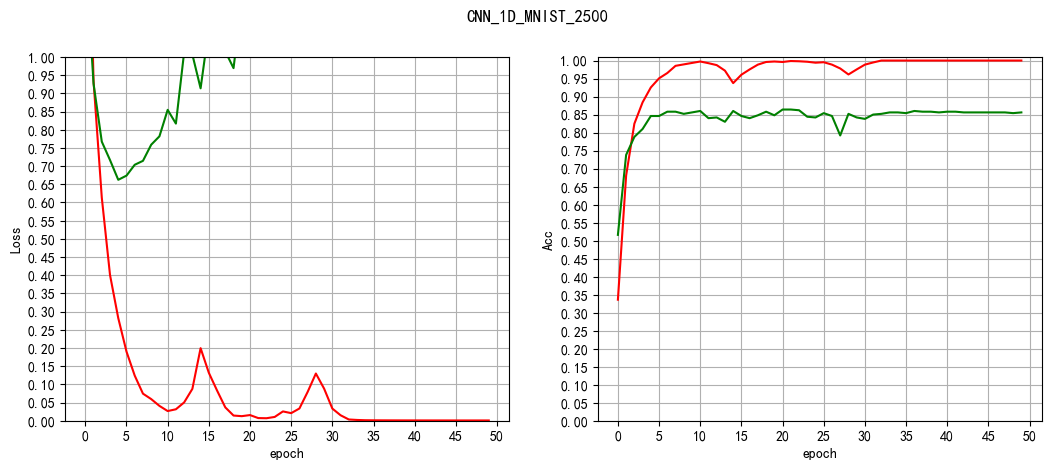

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

x = np.arange(0, 50)

width, height = 32, 12 
fig = plt.figure()
fig.suptitle("CNN_1D_MNIST_2500", fontsize=12)

fig.set_size_inches(width / 2.54, height / 2.54)

plt.subplot(1, 2, 1)  # fig.1是一个一行两列布局的图，且现在画的是左图
loss_1 = train_all_loss
loss_2 = val_all_loss
line1, = plt.plot(x, loss_1, color='r')
line2, = plt.plot(x, loss_2, color='g')
# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0, 1.0001, 0.05))
plt.ylim(0, 1)


plt.subplot(1, 2, 2)  # 当前图变为fig.1的右图
acc_1 = train_all_acc
acc_2 = val_all_acc

line1, = plt.plot(x, acc_1, color='r')
line2, = plt.plot(x, acc_2, color='g')

# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Acc")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0, 1.01, 0.05))
plt.ylim(0, 1.01)

plt.show()

In [12]:
model_Q = torch.load('Result/CNN_1D_MNIST_2500.pth', map_location=device)

totel_acc=0.0

for j, (inputs, labels) in enumerate(test_dataloader):
    outputs = model_Q(inputs)
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    totel_acc += acc.item() * inputs.size(0)
print('测试集500：')
print(totel_acc/test_data_size)

测试集500：
0.8560000009536743
